In [1]:
!pip install pygad
!pip install patsy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 1.2 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pad
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pygad
from pygad import torchga
from patsy import dmatrix

In [3]:
def matrix_decomp(x: torch.Tensor, n: int, sr: int):

    if x.dim() == 2:
        x = x[:,0]

    x_i = torch.full((n*sr,), float('nan'), dtype=torch.float32)
    pos = torch.arange(0, n)*sr
    x_i[pos] = x
    ones = torch.ones(x_i.shape[0], dtype=torch.float32)
    # Create 1.T
    ones = ones.unsqueeze(0)
    x_i = x_i.unsqueeze(1)
    X = torch.mm(x_i, ones)
    I = torch.eye(n*sr)
    I[I == 0] = float('nan')
    X = X*I
    return X

def shift(x: torch.Tensor, k=1):
    ''' shift the arrays'''
    if k > 0:
        y = torch.cat([torch.full((k,), float('nan')), x])
        y = y[:len(x)]
    elif k < 0:
        k = abs(k)
        y = torch.cat([x, torch.full((k,), float('nan'))])
        y = y[k:]
    else:
        y = x
    return y

def X_shift(X: torch.Tensor, sr: int, p: torch.Tensor):
    # First enlarge the array to include the largest positive time shift
    if torch.max(p) > 0:
        X_out = F.pad(X.clone().detach(), (0, X.shape[0]), mode='constant', value=float('nan'))
    else:
        X_out = X.clone().detach()

    # Shift the values
    for i in range(1, int(X.shape[0]/sr)):
        x_r = X_out[i*sr, :]
        x_shift = shift(x_r, int(p[i].item()))
        X_out[i*sr, :] = x_shift

    return X_out

def fill_nan_with_last_value(x):
    mask = torch.isnan(x)

    last = x[0].item()
    for i in range(1, x.shape[0]):
        if mask[i].item():
            x[i] = last
        elif mask[i].item() is False:
            last = x[i].item()
    return x


In [28]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np


class ShiftNetwork(nn.Module):
    def __init__(self, n, hidden_size, t, n_knots, opt_max=False):
        super(ShiftNetwork, self).__init__()

        # Settings
        self.n = n
        self.hidden_size = hidden_size
        self.n_knots = n_knots
        self.t = t
        self.sr = 10
        self.scale_factor=0.02
        self.opt_max = opt_max

        # Trainable Parameters
        self.B = nn.Parameter(torch.randn(n_knots))

        self.fc1 = nn.Linear(n, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

        # Utility Parameters  (likelihood)
        self.sigma = nn.Parameter(torch.zeros(1))
        self.sigma_t = nn.Parameter(torch.zeros(1))

    def set_opt_max(self, is_max):
        self.opt_max = is_max

    def basis_matrix(self):
        x = torch.arange(1, self.t + 1)  # Sample x values
        self.k_values = torch.arange(0, self.n_knots) * (self.t / self.n_knots)  # Values of k
        self.rw_interval = torch.diff(self.k_values)[0].item()
        X = self.create_basis(x, self.k_values)
        return X

    def fe_basis_matrix(self):
        ''' Alternate linear basis with 'hat' type basis'''
        x = np.arange(1, self.t + 1)
        y = dmatrix(f"bs(x, df={self.n_knots}, degree=1, include_intercept=False) - 1", {"x": x})
        self.k_values = torch.arange(0, self.n_knots) * (self.t / self.n_knots)
        self.rw_interval = torch.diff(self.k_values)[0].item()
        return torch.tensor(np.array(y), dtype=torch.float32)

    def piecewise_linear(self, x, k):
        y = x - k
        y[x < 0] = 0
        y[x < k] = 0
        return y

    def create_basis(self, x, k):
      num_x = len(x)
      num_k = len(k)
      b = torch.zeros((num_x, num_k))
      for i in range(num_k):
          b_i = self.piecewise_linear(x, k[i])
          b[:, i] = b_i
      return b

    def shift_rows(self, X, p):
        # Get the dimensions of the input matrix
        num_rows, num_cols = X.size()

        # Create an empty tensor of the same shape as the input matrix
        shifted_X = torch.torch.full((X.shape[0],X.shape[1]), float('nan'))

        # Iterate over each row of the input matrix
        for i in range(0, (len(p)-1)):
            # Get the shift value for the current row
            shift_amount = int(p[i].item())  # Convert tensor to scalar

            # Perform the row shifting operation
            shifted_X[i*self.sr, :] = torch.roll(X[i*self.sr, :], shifts=shift_amount, dims=0)

        return shifted_X


    def create_shift_matrix(self, p, n_max, tau=10, clamp_max=1000, pad=False):
        pp = p + torch.arange(p.shape[0]).unsqueeze(1)
        POS = torch.tensor(np.arange(p.shape[0])).repeat(p.shape[0],1)
        # Filter the empty rows
        POS = POS[::self.sr,::]
        pp = pp[::self.sr]
        # Iteratively multiply the matrix by itself, clamping each loop.
        power_ = (torch.abs(POS - pp) + 0.5)
        for i in range(tau):
          power_ = power_**2
        #  # Iteratively multiply
          power_ = torch.clamp(power_, max=clamp_max)

        P = torch.exp(-1*(power_))

        return P

    def shift_rows_differentiable(self, x, p):
        ''' x input should be the standard input x interleaved with nan values '''
        p_expand = torch.repeat_interleave(p, self.sr)
        # Create the shift matrix form
        P = self.create_shift_matrix(p_expand, n_max=p_expand.shape[0], tau=15, clamp_max=torch.tensor(1000), pad=False)
        # Replace zeros with NANs
        #P = P[::self.sr,:]
        # Expand the input x into the 2d shape
        B = x.view(-1, 1).expand(-1, p_expand.shape[0])

        # element wise multiply
        X_shift = P * B

        return X_shift,P

    def nan_mean(self, input):
        # Create a mask for NaN values
        mask = torch.isnan(input)

        # Replace NaN values with zeros
        input_zeros = torch.where(mask, torch.zeros_like(input), input)

        # Compute the sum and count of non-NaN values along each column
        col_sum = torch.sum(input_zeros, dim=0)
        col_count = torch.sum(~mask, dim=0, dtype=torch.float32)

        # Compute the column-wise mean, ignoring NaN values
        output = torch.where(col_count > 0, col_sum / col_count, torch.tensor(float('nan')))

        return output

    def fill_nan_with_last_value(self, x):
        mask = torch.isnan(x)

        last = x[0].item()
        for i in range(1, x.shape[0]):
            if mask[i].item():
                x[i] = last
            elif mask[i].item() is False:
                last = x[i].item()
        return x

    def conditional_posterior(self, d, u, sd, n_steps):
        ''' Posterior Conditional conditional on f(X | Xn = d) Distribution
        Multivariate gaussian distribution'''
        u = (d / n_steps)
        sd = torch.sqrt((sd ** 2) * (n_steps - 1) / n_steps)
        return u, sd

    def px_z(self, u1, u2, sd1, sd2):
        ''' Find the pdf of Z ~N(u2, sd2**2), given the parameters of X ~ (u1, sd1**2) '''

        # Define the constants
        alpha = torch.sqrt(1 / (2 * sd2**2) + 1 / (2 * sd1**2))
        alpha_beta = u2 / (2 * sd2**2) + u1 / (2 * sd1**2)
        gamma = (u2**2) / (2 * sd2**2) + (u1**2) / (2 * sd1**2)
        beta = alpha_beta / alpha

        # Define the components
        p1 = 1 / (2 * sd1 * sd2 * alpha * torch.sqrt(torch.tensor(np.pi)))
        p2 = torch.exp(-gamma + beta**2)

        return p1 * p2

    def reverse_softplus(self, x):
        if x > -10:
          return -torch.log(1 + torch.exp(-x))
        else:
          return x

    def expected_likelihood(self, d, u, sd, n_steps):
        ''' Analytical Solution to the Expected Likelihood
        Given a random walk what is the expected likelihood
        of the walk, given that it took n_steps and moved a vertical distance d'''
        post_u, post_sd = self.conditional_posterior(d, u, sd, n_steps)
        el = torch.log(self.px_z(u1=0, u2=post_u, sd1=sd, sd2=post_sd))
        # Apply a reversed softplus so that the values are bounded to P=1
        el = self.reverse_softplus(el * n_steps)
        return el

    def terror_likelihood(self, k_values, sd, RW_width, p):
            ''' Calculate the likelihood across on the time axis
            The returned value comprises the expected likelihood, calculated
            between each of the k knot values'''
            total_likelihood = 0
            k_values = torch.cat([k_values, torch.tensor(len(p)).unsqueeze(0) - 1])
            for i in range(1, len(k_values)):
              x1 = k_values[i-1]
              x2 = k_values[i]

              y1 = p[x1.to(torch.int)]
              y2 = p[x2.to(torch.int)]

              d = y2 - y1

              el = self.expected_likelihood(d, 0, sd, RW_width)
              total_likelihood = total_likelihood + el
            return total_likelihood

    def forward(self, x, basis_X):

        # shift parameters are dependent on the previous ones so they need scaling for the gradients
        # also clamp the B parameters before hand so they dont get so large.
        #B = torch.clamp(self.B, min=-30, max=30)
        p = torch.matmul(basis_X, self.B )
        p = p/self.scale_factor

        # Shift across the rows, take the mean and forward fill.
        x_shift, P = self.shift_rows_differentiable(x, p)
        P = torch.sum(P, dim=0)
        x_shift = torch.nansum(x_shift, dim=0)


        # Convert the mask zeros to NA values
        x_shift[torch.abs(P) < 1e-3] = float('nan')

        # Forward fill the NA values
        x_shift[0] = x[0]
        x_shift = self.fill_nan_with_last_value(x_shift)


        # Resample and reshape
        x_shift = x_shift[::self.sr]
        x_shift = x_shift[:len(p)]
        x_shift = x_shift.unsqueeze(1)

        # Apply the fc layers
        h1 = self.relu(self.fc1(x_shift))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        y = self.fc4(h3)
        return y.squeeze(1), p

    def predict_realisations(self,x,n,rw_realisation=True):
        realisations = []
        for i in range(n):
          y = self.predict(x, True).detach().numpy()
          realisations.append(y)
        return realisations

    def predict(self, x, rw_realisation=False):
        if rw_realisation is False:
          # Predict without any time shifting
          p = torch.matmul(basis_X, torch.tensor(torch.zeros(self.B.shape[0])))
        else:
          rw = np.cumsum(np.random.normal(0, np.exp(self.sigma_t.detach().numpy())*self.sr,size=x.shape[0]*self.sr), axis=0)
          p = torch.tensor(rw[::model.sr],dtype=torch.float32)

      # Shift across the rows, take the mean and forward fill.
        x_shift, P = self.shift_rows_differentiable(x, p)
        P = torch.sum(P, dim=0)
        x_shift = torch.nansum(x_shift, dim=0)


        # Convert the mask zeros to NA values
        x_shift[torch.abs(P) < 1e-3] = float('nan')

        # Forward fill the NA values
        x_shift[0] = x[0]
        x_shift = self.fill_nan_with_last_value(x_shift)


        # Resample and reshape
        x_shift = x_shift[::self.sr]
        x_shift = x_shift[:len(p)]
        x_shift = x_shift.unsqueeze(1)

        h1 = self.relu(self.fc1(x_shift))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        y = self.fc4(h3)
        return y.squeeze(1)

    def log_likelihood(self, y_pred, y, p):

        # Compute log likelihood of data given model parameters
        sigma = torch.exp(self.sigma)
        sigma_t = torch.exp(self.sigma_t)

        # Compute the error likelihood
        dist = Normal(loc=0, scale=sigma)
        ll = dist.log_prob(y_pred-y).sum()

        #Random walk shift likelihood
        tl = self.terror_likelihood(self.k_values, sigma_t, self.rw_interval, p)

        # Maximize for Pygad genetic, minimize for pytorch optimizers
        if self.opt_max is True:
          return (ll + tl)
        else:
          return -(ll + tl)

In [5]:
def generate_example_waves(n):
    np.random.seed(12)
    x = np.arange(1,n+1)/100
    x = 2*np.pi*x
    y1 = np.sin(x)
    y2 = np.sin(x) + np.random.normal(0, 0.5, size=n)
    return x, y1, y2


def generate_sample_perturbations(scale, n, type="gaussian", truncate=False, sr=10):
    perturbations = (np.random.normal(loc=0, scale=(scale - 1), size=n))
    perturbations = perturbations.astype("int")
    if truncate is True:
        perturbations[perturbations <= -1*sr] = -1*sr
    p_cum = np.cumsum(perturbations)
    return perturbations, p_cum

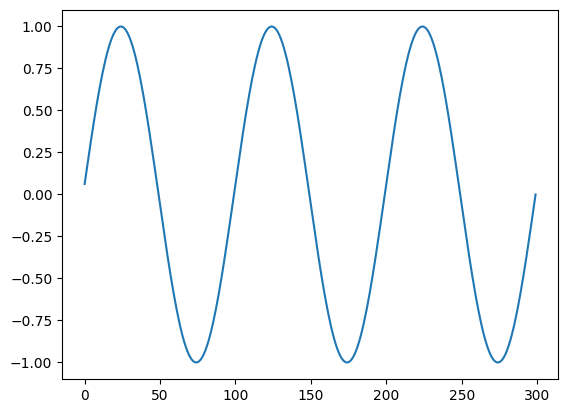

In [6]:
# Create sample waves
n=300
sr=10
z, x, y1 = generate_example_waves(n)
plt.plot(x)

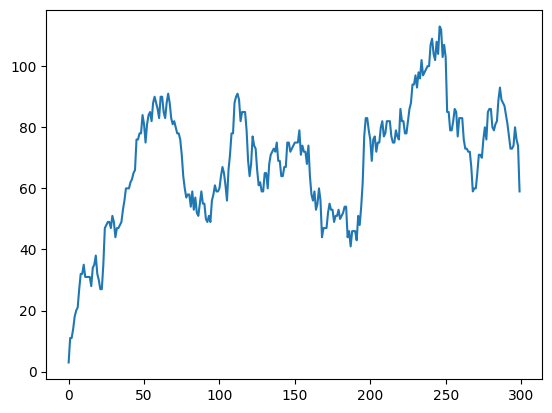

In [7]:
# Create perturbation profile
p_step, p = generate_sample_perturbations(6, n, truncate=False, sr=sr)
plt.plot(p)

In [8]:
# Example usage
x = torch.tensor(x, dtype=torch.float32)
#print(x)
X = matrix_decomp(x, n, sr)
print(X.grad_fn)

X_s = X_shift(X, sr, torch.tensor(p))
print(X_s.grad_fn)

x_s = torch.nanmedian(X_s, dim=0).values
x_out = fill_nan_with_last_value(x_s)

# Downsample
y = x_out[::sr]
print(x_out.grad_fn)
y = y[:len(x)]
print(y.shape)

None
None
None
torch.Size([300])


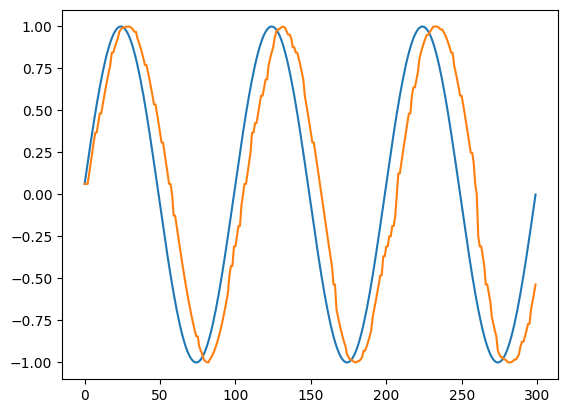

In [9]:
plt.plot(x)
plt.plot(y)
x = x.unsqueeze(1)

In [10]:
x = x.to(torch.float32)
y = y.to(torch.float32)

# Initialise the perturbation network
model = ShiftNetwork(n=1, hidden_size=5, t=n, n_knots=5, opt_max=True)
#basis_X = model.basis_matrix()
basis_X = model.fe_basis_matrix()


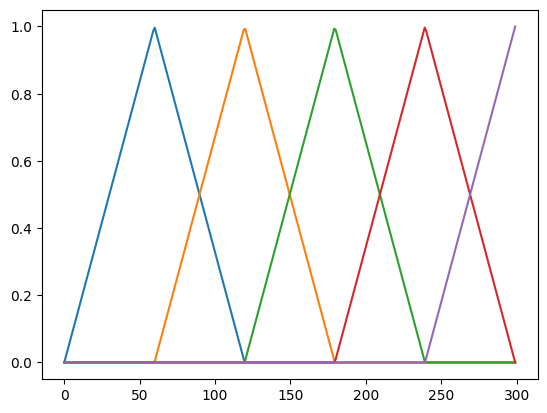

In [11]:
plt.plot(basis_X.detach().numpy())

## Genetic Algo Training

In [12]:
def fitness_func(ga_instance, solution, sol_idx):
    global x, basis_X, y, torch_ga, model
    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)


    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    y_pred, p = model(x, basis_X)

    ll = model.log_likelihood(y_pred, y, p)
    ll = ll.detach().numpy()

    solution_fitness = ll#1.0 / ll

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))


In [13]:
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=200)

In [14]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 100 # Number of generations.
num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       sol_per_pop=200,
                       num_genes = len(initial_population),
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [ ]:
torch.set_grad_enabled(False)
# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

Generation = 1
Fitness    = [-539.6623]
Generation = 2
Fitness    = [-473.7432]
Generation = 3
Fitness    = [-400.8815]
Generation = 4
Fitness    = [-374.13068]
Generation = 5
Fitness    = [-367.2679]
Generation = 6
Fitness    = [-364.746]
Generation = 7
Fitness    = [-364.746]
Generation = 8
Fitness    = [-347.6775]
Generation = 9
Fitness    = [-337.92273]
Generation = 10
Fitness    = [-337.92273]
Generation = 11
Fitness    = [-312.21747]
Generation = 12
Fitness    = [-250.22728]
Generation = 13
Fitness    = [-173.50969]
Generation = 14
Fitness    = [-173.50969]
Generation = 15
Fitness    = [-173.50969]
Generation = 16
Fitness    = [-173.50969]
Generation = 17
Fitness    = [-173.50969]
Generation = 18
Fitness    = [-173.50969]
Generation = 19
Fitness    = [-150.7677]
Generation = 20
Fitness    = [-147.7358]
Generation = 21
Fitness    = [-124.871086]
Generation = 22
Fitness    = [-124.871086]
Generation = 23
Fitness    = [-119.499886]
Generation = 24
Fitness    = [-106.11833]
Generatio

In [16]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
y_pred, p = model(x, basis_X)

Fitness value of the best solution = [182.03745]
Index of the best solution : 0


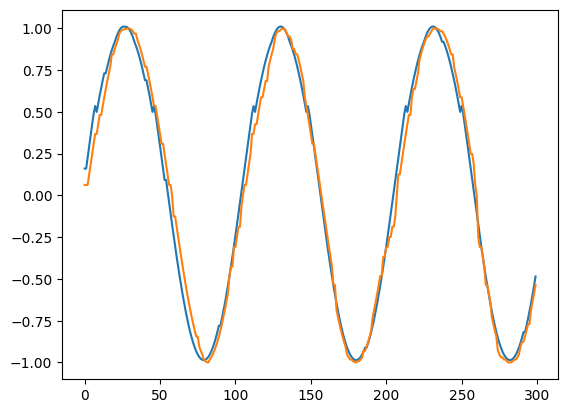

In [17]:
plt.plot(y_pred.detach().numpy())
plt.plot(y)
plt.show()

In [18]:
model.B

Parameter containing:
tensor([0.9067, 1.1142, 1.1808, 1.4159, 1.6390], requires_grad=True)

In [337]:
for name, param in model.named_parameters():
    if name == 'B' or name == 'sigma_t':
      print(f"Freezing:{name}")
      param.requires_grad = True

Freezing:B
Freezing:sigma_t


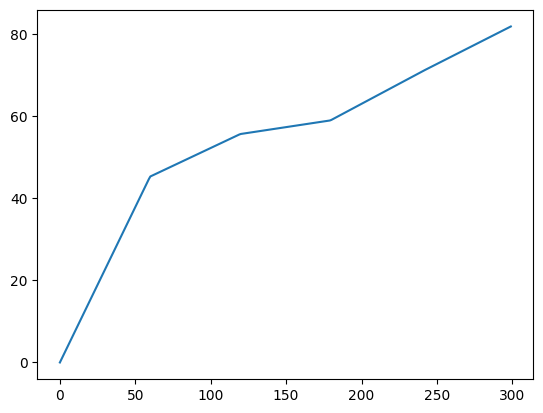

In [19]:
plt.plot(p.detach().numpy())

# Plot Potential Shifts

In [20]:
# Plot random walks with the estimated parameters, see how our basis estimate looks
rw = np.cumsum(np.random.normal(0, np.exp(model.sigma_t.detach().numpy())*model.sr,size=(100,3000)), axis=1)

Text(0.5, 1.0, '100 Random Walks with Estimated Perturbations overlayed (Dark Blue)')

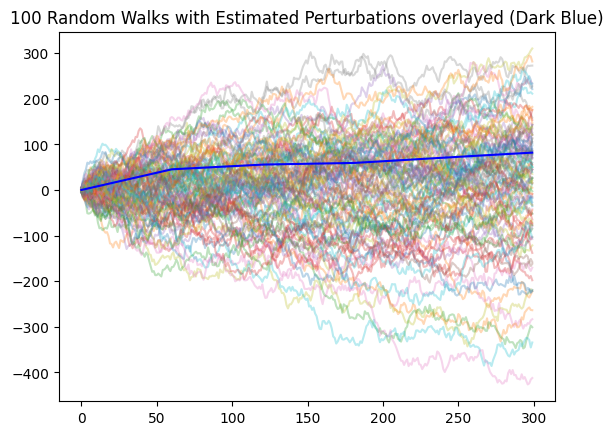

In [21]:
plt.plot(rw[:,::model.sr].T, alpha=0.3)
plt.plot(p.detach().numpy(), color="blue")
plt.title('100 Random Walks with Estimated Perturbations overlayed (Dark Blue)')

In [22]:
np.exp(model.sigma_t.detach().numpy())*model.sr

array([2.7147903], dtype=float32)

In [34]:
# Predict realisations
rw_predictions = predict_realisations(x, 400, model)
#Stack the paths into a single array and plot
all_paths = np.stack(rw_predictions)

In [35]:
# Calculate the quantiles
q10 = np.quantile(all_paths, axis=0, q=0.10)
q90 = np.quantile(all_paths, axis=0, q=0.90)
q50 = np.quantile(all_paths, axis=0, q=0.50)

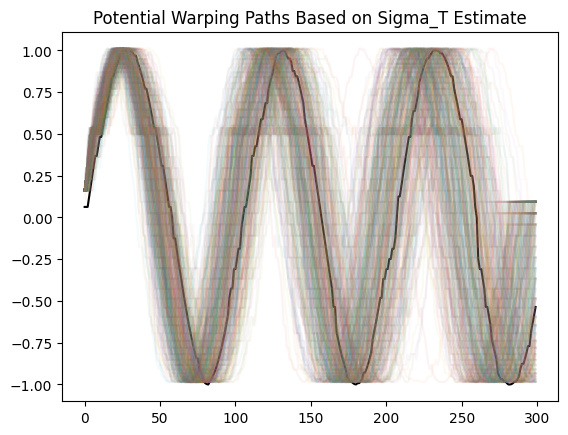

In [43]:
# Plot the raw paths
plt.plot(y, color="black")
plt.plot(all_paths.T, alpha=0.05)
plt.title('Potential Warping Paths Based on Sigma_T Estimate')
plt.show()

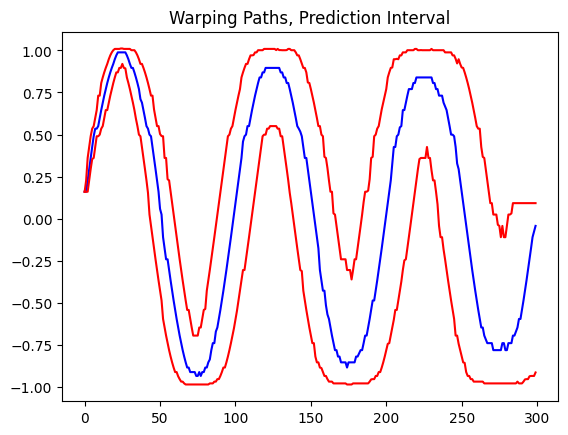

In [44]:
# Plot the quantiles
plt.plot(q50, color="blue")
plt.plot(q10, color="red")
plt.plot(q90, color="red")
plt.title("Warping Paths, Prediction Interval")
plt.show()